## Model: KNN Tree
Attribute Selection: None

In [14]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

def interpret_confusion_matrix(matrix):
    information=[]
    i=0
    for row in matrix:
        total = sum(row)
        correct = row[i]
        
        consider = row.tolist() 
        del consider[i] #remove correctly classified instances

        errors = sum(consider)
        information.append([i,correct,errors,total])
        i+=1
    print(tabulate(information,headers=["Class","Correctly Classified","Incorrectly Classified","Total"]))

def determine_n_value(xtrain,ytrain,xtest,ytest):
    stats = [] # n value, error rate, cross validation score
    error =[]
    cv = []
    for k in range(1,25):
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(xtrain,ytrain)
        ypred = clf.predict(xtest)
        cv_score=cross_val_score(clf,xtrain,ytrain, cv=10)
        error_rate = np.mean(ypred!=ytest)
        stats.append([k,np.round(error_rate,4),np.array(cv_score).mean()])
        error.append(np.round(error_rate,4))
        cv.append(np.array(cv_score).mean())

    #Plot results    
    data = [error, cv]
    titles = ['Error Rate vs. K Value (KNN)','Cross Validation Score vs. K Value (KNN)']
    colors = ["blue","r"]
    y_labels =['Error Rate','Cross Validation Score']
    fig,axis = plt.subplots(2,1)
  
    plt.figure(figsize=(20,6))
    for i in range(2):      
        axis[i].plot(range(1,25),data[i],color=colors[i], linestyle='dashed',marker='o',markerfacecolor=colors[i], markersize=5)
        axis[i].set_title(titles[i],loc='left', fontweight='bold',  style='italic',)
        axis[i].set_xlabel('K')
        axis[i].set_ylabel(y_labels[i])

    fig.tight_layout()
    plt.show()
    return stats

In [2]:
df = pd.read_csv("Data/DataEncoded.csv")

X=df.iloc[:,:-1]
y=df["NObeyesdad"]

#### Training, Testing

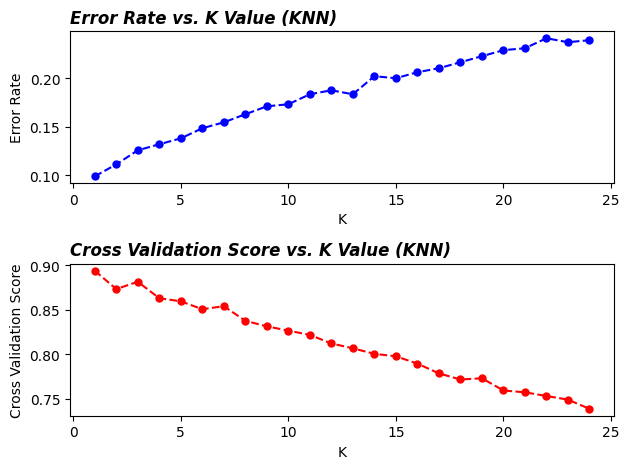

<Figure size 2000x600 with 0 Axes>

  K    Error Rate    Cross Validation Score
---  ------------  ------------------------
  1        0.099                   0.894072
  2        0.1113                  0.873434
  3        0.1258                  0.881701
  4        0.132                   0.863122
  5        0.1381                  0.859688
  6        0.1485                  0.850742
  7        0.1546                  0.854195
  8        0.1629                  0.837681
  9        0.1711                  0.831493
 10        0.1732                  0.826675
 11        0.1835                  0.821847
 12        0.1876                  0.81223
 13        0.1835                  0.806741
 14        0.2021                  0.800538
 15        0.2                     0.797789
 16        0.2062                  0.789542
 17        0.2103                  0.778536
 18        0.2165                  0.771663
 19        0.2227                  0.773033
 20        0.2289                  0.759282
 21        0.2309                

In [3]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,stratify=y)

# determine n value
consider_n = determine_n_value(X_train,y_train,X_test,y_test)

print(tabulate(consider_n,headers=["K","Error Rate","Cross Validation Score"]))


You do not want a K value that is too small, this leads me to overfitting. With that being said, we will use k = 4 since the cross validation score is high as well.

In [4]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
ypred = knn.predict(X_test)


#### Visualization

In [5]:
# plot_decision_regions(X_train.values, y_train.values, clf=knn, legend=6)
# # Adding axes annotations
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.title("Knn with K=7")
# plt.show()

#### Evaluation

Cross Validation Score: 0.86312234293812
Precision Score: 0.868397678969582
Recall Score: 0.8680412371134021
F1 score: 0.8625762674821026

Confusion Matrix 
----------------


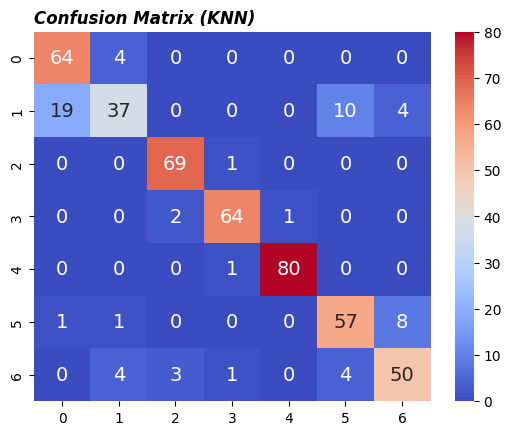

  Class    Correctly Classified    Incorrectly Classified    Total
-------  ----------------------  ------------------------  -------
      0                      64                         4       68
      1                      37                        33       70
      2                      69                         1       70
      3                      64                         3       67
      4                      80                         1       81
      5                      57                        10       67
      6                      50                        12       62


In [15]:
cv_score = np.array(cross_val_score(knn, X_train,y_train, cv=10)).mean()
cf_matrix = confusion_matrix(y_test,ypred)
metrics = precision_recall_fscore_support(y_test,ypred,average="weighted")
precision,recall,f1=metrics[0],metrics[1],metrics[2]

print("Cross Validation Score: {0}\nPrecision Score: {1}\nRecall Score: {2}\nF1 score: {3}".format(cv_score,precision,recall,f1))

print("\nConfusion Matrix \n----------------")
sns.heatmap(pd.DataFrame(cf_matrix, range(7), range(7)), annot=True, annot_kws={"size": 14},cmap = 'coolwarm') # font size
plt.title("Confusion Matrix (KNN)",loc='left', fontweight='bold',  style='italic')
plt.show()

interpret_confusion_matrix(cf_matrix)                   